# Risk Calculator

While playing [Risk](https://en.wikipedia.org/wiki/Risk_(game%29), sometimes I get frustrated with huge variance of outcomes of battle. Strategy games shouldn't be too random, right? To check, whether it is just my bias, or fights are really unpredictable, I decided to calculate probabilities of winning and units expected to survive after battle.

To conquer a new territory, player needs to move as much units as he wants to attack with to adjacent field of another player. However, attacker must leave at least one soldier. After that, the fight begins. How does fight look like in Risk? Fight consists of turns. In one turn, attacker rolls three six-sided dices (or less, if he has less than 3 soldiers) and defender rolls two dices (or one, if he has only one soldier alive). After rolling, player compare their respective highest scores. If attacker has higher score on his dice, one defender dies. Otherwise, one attacker dies. Players repeat turns until one of them loses all soldiers.

Example: Player 1 has 5 units in North Africa and player 2 has 3 units in Egypt. Player 1 decides to attack with highest possible power and moves 4 units from North Africa to Egypt. The fight begins:
 * In first turn, attacker rolls 3 dices and defender rolls 2 dices. Player 1 rolls 2, 4 and 5 and player 2 rolls 4, 4. We compare 5 (highest roll of player 1) and 4 (highest roll of player 2). Since player 1 rolls higher, defender loses one unit. We also compare 4 (second highest roll of player 1) and 4 (second highest roll of player 2). In case of tie, defender wins and attacker loses one unit. After this turn, attacker has 3 units and defender has 2 units.
 * In second turn, attacker rolls 3 dices and defender rolls 2 dices. Player 1 rolls 1, 3 and 3 and player 2 rolls 2, 4. Both players lose one unit.
 * In third turn, attacker rolls 2 dices (since he has 2 units) and defender rolls one dice only (since he has one unit). Attacker rolls 4 and 6. However, defender rolls 6 and attacker loses one unit.
 * Last turn is 1 vs 1. Both players roll 3, so defender wins.
 * After fight, player 1 has 1 unit in North Africa and player 2 has 1 unit in Egypt.

In [1]:
%matplotlib nbagg
import itertools
import numpy
from matplotlib import pyplot
from mpldatacursor import datacursor


# Maximum army size (for calculations)
N = 40

# How to interpret values for matrix?
# Assume that attacker has a unit and defender has d units.
# Row matrix[a][d] gives probabilities of all possible results.
# Matrix[a][d][N - s] = P(defender won and s units survived)
# Matrix[a][d][N - 1 + s] = P(attacker won and s units survived)
matrix = numpy.zeros((N + 1, N + 1, 2 * N))

At first, we need to have probabilities in edge cases.

In [2]:
for i in range(N + 1):
    matrix[0][i][N - i] = matrix[i][0][N - 1 + i] = 1

While we will never fight versus 0 units, these values are used for calculations and it's quite obvious, that after "fight" versus 0 units nobody dies. To simulate turns, we will use this function:

In [3]:
def single_turn(atk_dices, def_dices):
    defenders_dying = [0, 0, 0]
    dices_to_compare = min(atk_dices, def_dices)  # 1 or 2
    dice = list(range(6))
    for atk_rolls in itertools.product(dice, repeat=atk_dices):
        for def_rolls in itertools.product(dice, repeat=def_dices):
            atk_rolls = sorted(atk_rolls, reverse=True)[:dices_to_compare]
            def_rolls = sorted(def_rolls, reverse=True)[:dices_to_compare]
            index = 0
            for i in range(dices_to_compare):
                if atk_rolls[i] > def_rolls[i]:
                    index += 1
            defenders_dying[index] += 1
    scenarios_total = sum(defenders_dying)
    return [x / scenarios_total for x in defenders_dying]

It checks every possible scenario for its result. Since we will roll at most 5 dices, it doesn't take much time. Function return list `defenders_dying`, which tells us probability of defenders dying in one turn: `defenders_dying[i]` $= P(i \text{ defenders died})$. Since for every comparision of dices one unit dies, we can deduce, how many attackers died.

In [4]:
# 1 attacker vs 1 defender
result_1vs1 = single_turn(1, 1)
matrix[1][1][N - 1] = result_1vs1[0]
matrix[1][1][N] = result_1vs1[1]

# 1 attacker vs d defenders (d > 1)
result_1vs2 = single_turn(1, 2)
for d in range(2, N + 1):
    for s in range(N - d, N + 1):
        matrix[1][d][s] = (result_1vs2[0] * matrix[0][d][s]
                           + result_1vs2[1] * matrix[1][d - 1][s])

# 2 attackers vs 1 defender
result_2vs1 = single_turn(2, 1)
# First scenario: attackers kill defender on first try
matrix[2][1][N + 1] = result_2vs1[1]
# Second scenario: on first try attackers fail
# On second try, there is 1vs1 and attacker wins
matrix[2][1][N] = result_2vs1[0] * matrix[1][1][N]
# Third scenario: defender rolls the highest score twice and survives
matrix[2][1][N - 1] = result_2vs1[0] * matrix[1][1][N - 1]

# 2 attackers vs d defenders (d > 1)
result_2vs2 = single_turn(2, 2)
for d in range(2, N + 1):
    for s in range(N - d, N + 2):
        matrix[2][d][s] = (result_2vs2[0] * matrix[0][d][s]
                           + result_2vs2[1] * matrix[1][d - 1][s]
                           + result_2vs2[2] * matrix[2][d - 2][s])

# a attackers vs 1 defender (a > 3)
result_3vs1 = single_turn(3, 1)
for a in range(3, N + 1):
    for s in range(N - 1, N + a):
        matrix[a][1][s] = (result_3vs1[0] * matrix[a - 1][1][s]
                           + result_3vs1[1] * matrix[a][0][s])

Equations here are very simple, we just multiply and add some related probabilities. Now that we have all edge cases, we can simulate all fights:

In [5]:
result_3vs2 = single_turn(3, 2)
for a in range(3, N + 1):
    for d in range(2, N + 1):
        for s in range(N - d, N + a):
            matrix[a][d][s] = (result_3vs2[0] * matrix[a - 2][d][s]
                               + result_3vs2[1] * matrix[a - 1][d - 1][s]
                               + result_3vs2[2] * matrix[a][d - 2][s])

And that's it. Now, let's visualize our data. At first, we would like to know, what is our chance to win at all.

In [6]:
win_percentage = numpy.empty((N, N))
for i in range(N):
    for j in range(N):
        win_percentage[i][j] = numpy.sum(matrix[i + 1][j + 1][N:])

Let's create a 2D color grid. Click on square in related coordinates to see exact chances of winning. 

<IPython.core.display.Javascript object>


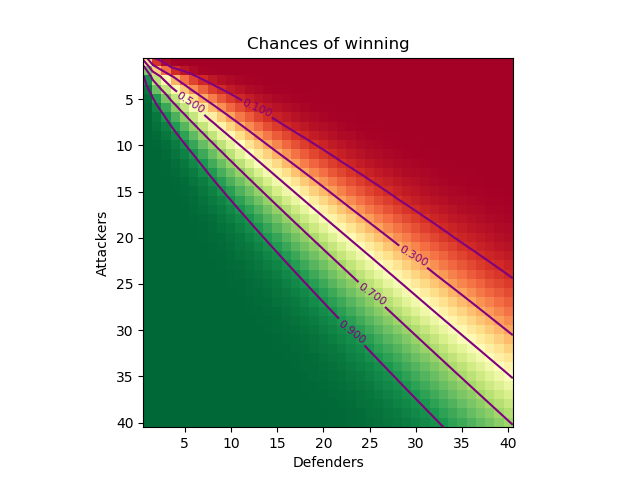

In [7]:
# Formatter for first graph cursor (probability of winning)
def formatter(**kwargs):
    kwargs['i'] += 1
    kwargs['j'] += 1
    text = "{i} attacker"
    if kwargs['i'] > 1:
        text += "s"
    text += " vs {j} defender"
    if kwargs['j'] > 1:
        text += "s"
    text += "\nProbability of winning: {z:.4f}"
    return text.format(**kwargs)


# Visualize data
pyplot.figure(1)
grid_extent = [0.5, N + 0.5, N + 0.5, 0.5]
pyplot.imshow(win_percentage, cmap='RdYlGn', extent=grid_extent)
pyplot.title("Chances of winning")
pyplot.xlabel("Defenders")
pyplot.ylabel("Attackers")
datacursor(formatter=formatter, bbox=dict(alpha=1))
contour_label = [0.1, 0.3, 0.5, 0.7, 0.9]
contour_extent = [0.5, N + 0.5, 0.5, N + 0.5]
contour_graph = pyplot.contour(win_percentage, contour_label, colors='purple',
                               extent=contour_extent)
pyplot.clabel(contour_graph, inline=True, fontsize=8)
pyplot.show()

Grid also contains five contour lines. Simple observations (they are not precisely true for small fights):
 * Defender needs about 15% units more to have 50% chance to win.
 * If attacker has 10% more units than defender, he is almost certain to win (about 90% chance).
 * However, if defender wants to be almost certain of his victory (about 90% chance), he needs about 50% units more than attacker.

While these observations are not true for large numbers (when both sides have 300 units, attacker has 95% chance to win), during all the games I've played there was never a fight with more than 40 units on one side. Also, huge fights happen only once in a while to conquer key areas, while most of the fights are small (2 versus 1, 3 versus 2, 6 versus 4, ...).

Now, let's check, how many units are expected to survive. Let's choose example values:

In [8]:
attackers = 12
defenders = 15

We will create two bar graphs with probabilities of surviving:

<IPython.core.display.Javascript object>


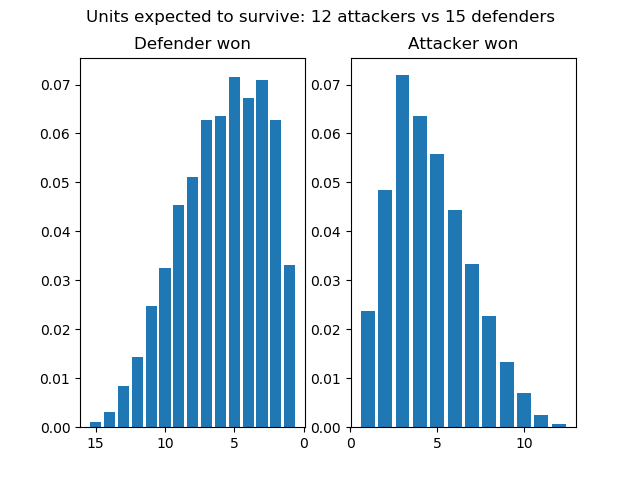

In [9]:
pyplot.figure(2)
suptitle = ("Units expected to survive: " + str(attackers) + " attacker"
            + ("s" if attackers > 1 else "") + " vs " + str(defenders)
            + " defender" + ("s" if defenders > 1 else ""))
pyplot.suptitle(suptitle)

subplot1 = pyplot.subplot(121)
defenders_row = matrix[attackers][defenders][(N - defenders):N]
pyplot.bar(numpy.arange(defenders, 0, -1), defenders_row)
pyplot.title("Defender won")
# Reverse x axis
xmin, xmax = pyplot.xlim()
pyplot.xlim(xmax, xmin)

pyplot.subplot(122, sharey=subplot1)
attackers_row = matrix[attackers][defenders][N:(N + attackers)]
pyplot.bar(numpy.arange(1, attackers + 1), attackers_row)
pyplot.title("Attacker won")

pyplot.show()

For large amount of units split among sides such that chances to win are about 50% (for example 33 vs 38) results line up almost in normal distribution, with one notable exception: when close to the middle, curve is rigged and there is a large hole in the middle (one defender stays alive, one or two attackers stay alive). This is due to the fact that when either side didn't roll all of his dices, he is significantly more likely to lose (defender in 3 versus 1 situation has less than 10% chances to survive and in 2 versus 2 situation defender has over 40% chance to not lose any unit).

# Conclusion

In single fight, attacker is slightly favored in fight (this is partially negated by the fact that attacker can't move all of his units from area). While attacker can't group units from several areas, defender can't support his areas, so this is irrelevant (unless one side has controls significantly more areas and in this cases he is more likely to win due to unit income). Most of the frustrations comes from losing small fights, that you're expected to win (for example, in 4 versus 2 fight you have over 20% chance to lose).

However, this is by no means trying to solve the game. Risk is a strategy game and you will usually win it through decision-making and alliances. Unlucky fights might ruin your small plans, but it's important to have alternatives and adapt to small defeats.